Copyright 2022–2024 Richard Laugesen

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



# Compare alternative decision rules on a value diagram

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from ruvpy.relative_utility_value import relative_utility_value
from ruvpy.damage_functions import binary
from ruvpy.economic_models import cost_loss, cost_loss_analytical_spend
from ruvpy.utility_functions import cara
from ruvpy.decision_rules import optimise_over_forecast_distribution, critical_probability_threshold_equals_par, critical_probability_threshold_fixed, critical_probability_threshold_max_value

# Load example forecast dataset

In [2]:
# Steamflow at Biggara in the Murray catchment of the southern Murray-Darling basin
# Subseasonal streamflow forecasts from MuTHRE and event frequency for reference

# load and convert runoff to cumecs
data = pd.read_csv('example_data/401012-muthre.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')
data *= 1165 / 86.4

# use forecasts from first 7 days
data = data[data.index.day <= 7]

# fetch the obs and forecast ensemble
obs = data['obs']
fcst = data[[col for col in data.columns if col.startswith('ens-')]]

# RUV library expects numpy arrays
obs = obs.values
fcst = fcst.values

print(obs.shape, fcst.shape)

(1932,) (1932, 100)


# Define decision context

In [3]:
parallel_nodes = 2

alpha_step = 0.05
alphas = np.arange(alpha_step, 1, alpha_step)
decision_threshold = np.nanquantile(obs, 0.75)

# note there is no decision_rule defined, we will add this before calling relative_utility_value
decision_context = {
    'damage_function': [binary, {'max_loss': 1, 'min_loss': 0, 'threshold': decision_threshold}],
    'utility_function': [cara, {'A': 0}],
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'decision_thresholds': np.array([0, decision_threshold])
}

ref = None  # tell RUV library to use obs to replicate event frequency reference as in REV

# Calculate RUV using different decision rules

In [7]:
results = pd.DataFrame(index=alphas, columns=['max value', 'threshold equals alpha', 'fixed threshold 10th', 'fixed threshold 50th', 'fixed threshold 90th', 'full ensemble'])

In [ ]:
decision_context['decision_rule'] = [optimise_over_forecast_distribution, None]
results['full ensemble'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [8]:
decision_context['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.1}]
results['fixed threshold 10th'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [9]:
decision_context['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.5}]
results['fixed threshold 50th'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [10]:
decision_context['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.9}]
results['fixed threshold 90th'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [11]:
decision_context['decision_rule'] = [critical_probability_threshold_max_value, None]
results['max value'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [12]:
decision_context['decision_rule'] = [critical_probability_threshold_equals_par, None]
results['threshold equals alpha'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

# Plot results on a value diagram

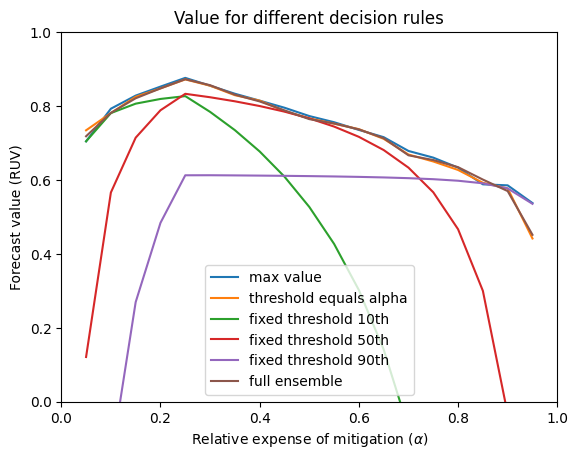

In [18]:
results.plot()
plt.xlim((0, 1))
plt.ylim(0, 1)
plt.xlabel(r'Relative expense of mitigation ($\alpha$)')
plt.ylabel('Forecast value (RUV)') 
plt.title('Value for different decision rules')
plt.legend()